# Assignment 3:  ridge regression

Due date:  Friday 10/5 at 11:59pm

**Rohan Jhaveri**


## Preliminaries 

In this assignment you will explore ridge regression applied to the task of predicting wine quality.
You will use the [wine quality](http://archive.ics.uci.edu/ml/datasets/Wine+Quality)
dataset from the UCI machine learning repository, and compare accuracy obtained using ridge regression to the results from a [recent publication](http://www.sciencedirect.com/science/article/pii/S0167923609001377#).
If you have trouble accessing that version of the paper, here's a link to a [preprint](http://www3.dsi.uminho.pt/pcortez/wine5.pdf).
The wine data is composed of two datasets - one for white wines, and one for red wines.  In this assignment perform all your analyses on just the red wine data.

The features for the wine dataset are not standardized, so make sure you do this, especially since we are going to consider the magnitude of the weight vector (recall that standardization entails subtracting the mean and then dividing by the standard deviation for each feature; you can use  Numpy/scikit-learn to perform this computation.


## Part 1

Implement ridge regression in a class called RidgeRegression that implements the classifier API, i.e. ``fit`` and ``predict`` methods with the same signature as the classifiers you implemented in the previous assignment.  Also implement functions for computing the following measures of error:

  * The Root Mean Square Error (RMSE).
  * The Maximum Absolute Deviation (MAD).

For a hypothesis $h$, they are defined as follows:

$$RMSE(h) = \sqrt{\frac{1}{N}\sum_{i=1}^N (y_i - h(\mathbf{x}_i))^2}$$

and

$$MAD(h) = \frac{1}{N}\sum_{i=1}^N |y_i - h(\mathbf{x}_i)|.$$

With the code you just implemented, your next task is to explore the dependence of validation-set error on the value of the regularization parameter, $\lambda$.
In what follows set aside 30% of the data for validation, and compute the in-sample error, and the validation-set error as a function of the parameter $\lambda$ on the red wine data.  Choose the values of $\lambda$ on a logarithmic scale with values 0.01, 0.1, 1, 10, 100, 1000 and plot the RMSE.
Repeat the same experiment where instead of using all the training data, choose 20 random examples out of the training set, and train your model using those 20 examples, while evaluating on the same validation set.

Now answer the following:

  * What is the optimal value of $\lambda$?
  * What observations can you make on the basis of these plots?  (The concepts of overfitting/underfitting should be addressed in your answer).
  * Finally, compare the results that you are getting with the published results in the paper linked above.  In particular, is the performance you have obtained comparable to that observed in the paper?  Please note that for a completely fair comparison, the comparison needs to be made on a separate test set, in the same way the experiment was performed in the paper.


**Answers**

* The optimal value for $\lambda$ for current partition is 10 when we split the dataset into 70% training and 30% validation. Whereas the best value of $\lambda$ is 100 when we just take 20 training samples. But it is observed that the optimal value of lambda was toggling between 10 and 100 as we randomly shuffled the dataset and partitioned it into 70% training and 30% validation set. But the learning trend always remained the same.


* The first set of plots for RMSE and MAD generated for 70% training and 30% validation data suggest that the model is following in the trend i.e. the $\lambda$ values almost fit the validation set (for both RMSE and MAD). But this is not the case with the second set of plots where we create the model by taking 20 ramdom samples of training data and test it on 30% of our validation set. This is becasue of lack of training data the model is overfitted and the prediction is not accurate after a certain value of $\lambda$.


* Comparing our results with the results in the published paper, we can say that our ridge regression model is performing very similar to the machine learning algorithms implemented in the paper (MR, NN, SVM). Especially, we can say that the Multiple regressions (MR) and Neural Networks (NN) results in the paper are very close to the results generated by our ridge regression algorithm.  

**Importing Packages**

In [49]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from numpy import linalg as la
import random as rand
from io import StringIO
import csv
import pandas as pd
from sklearn.model_selection import train_test_split #This packet splits the data set into training and testing 
                                                     #dataset with stratified partionong keeping the ratio of both 
                                                     #the dataset constant 
from sklearn import preprocessing
import math
from scipy.integrate import simps
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

**Partition function**

In [50]:
def partition(X,T,trainFraction=0.70, validateFraction=0.30):
    '''Usage: Xtrain,Ttrain,Xval,Tval = partition(X,T,0.8,0.2)'''
    n = X.shape[0]
    nTrain = round(trainFraction * n)
    nValidate = round(validateFraction * n)
    if nTrain + nValidate != n:
        nValidate = n - nTrain
# Random order of data matrix row indices
    rowIndices = np.arange(X.shape[0])
    np.random.seed(0)
    np.random.shuffle(rowIndices)
# Build X and T matrices by selecting corresponding rows for each partition
    Xtrain = X[rowIndices[:nTrain],:]
    Ttrain = T[rowIndices[:nTrain],:]
    Xvalidate = X[rowIndices[nTrain:nTrain+nValidate],:]
    Tvalidate = T[rowIndices[nTrain:nTrain+nValidate],:]
    return Xtrain,Ttrain,Xvalidate,Tvalidate#,Xtest,Ttest

**Data Extraction**

In [51]:
dataArray = pd.read_csv("red_wine.csv", delimiter=";")
dataArray = dataArray.values
X = dataArray[:,0:11]
T = dataArray[:,11]
T = T.reshape(-1,1)
Xtrain,Ttrain,Xvalidate,Tvalidate = partition(X,T)
X1 = dataArray
rand.shuffle(X1)
X2 = X1[0:20,0:11]
TX2 = X1[0:20,11]
TX2=TX2.reshape(-1,1)

**Ridge Regression Class**

In [52]:
class RidgeRegression:

    def fit(self,Xtrain,T,lamb):
        means = Xtrain.mean(0)  #Calculating mean
        stds = Xtrain.std(0)    #Calculating standard Deviation
        n,d = Xtrain.shape
        Xs1 = (Xtrain - means)/stds   #Standardizing Dataset
        lambDiag = np.eye(d+1) * lamb #Making lambda matrix 
        lambDiag[0,0] = 0    #Making first element of of lamda matrix as 0 
        Xs1 = np.insert(Xs1, 0, 1, axis=1)   #Adding bias term to the dataset
        self.w = np.zeros(len(Xs1[0]))    #Initailize weight matix to zero
        w = np.linalg.lstsq( Xs1.T @ Xs1 + lambDiag, Xs1.T @ T)[0] #Calculating the weight
        return {'w': w, 'means': means, 'stds': stds}

    def predict(self,model, Xtrain):
        Xs1 = np.insert((Xtrain-model['means'])/model['stds'], 0, 1, axis=1) #Standardizing and adding bias to the dataset
        return Xs1 @ model['w']

    def rmse(self,A,B):
        return np.sqrt(np.mean( (A-B)**2 ))   # Calculating RMSE
    
    def mad(self,A,B):
        return np.mean(abs(A-B))      #Calculating MAD 

    def evaluate_rmse(self,model, Xtrain, T):
        return self.rmse(self.predict(model, Xtrain), T)
    
    def evaluate_mad(self,model, Xtrain, T):
        return self.mad(self.predict(model, Xtrain), T)

**Main function**

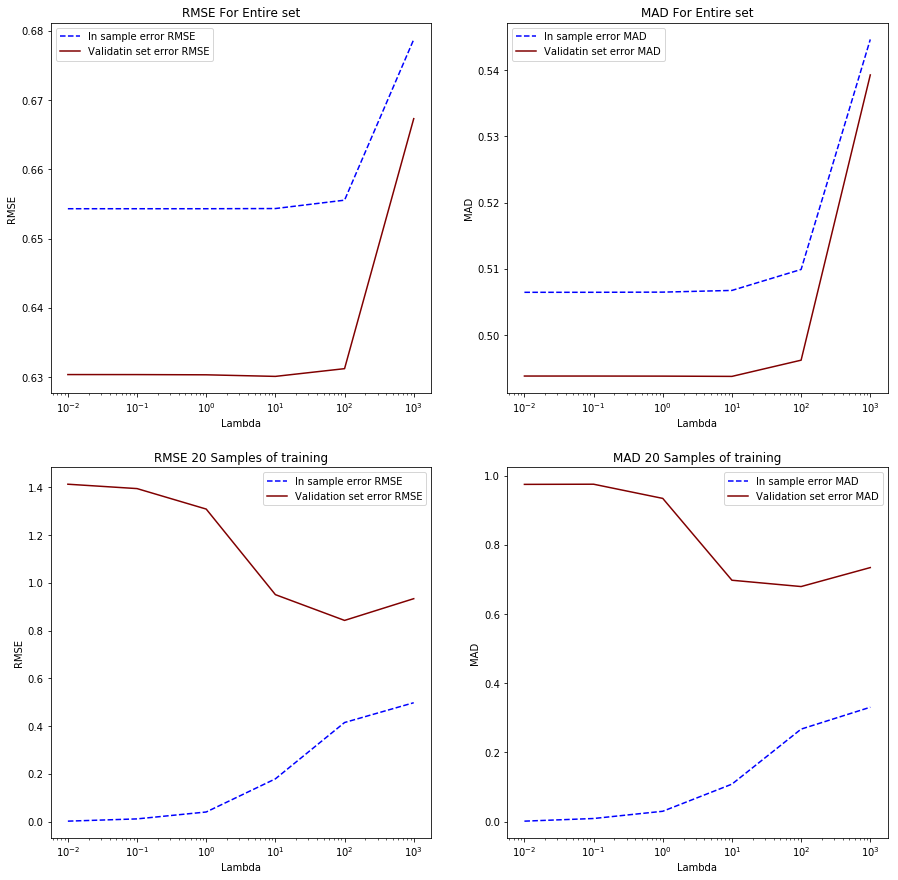

In [53]:
if __name__=='__main__' :
    r = RidgeRegression()
    results = []
    lambdas = [0.01, 0.1, 1, 10, 100, 1000]
    for lamb in lambdas:
        model = r.fit(Xtrain, Ttrain, lamb)
        results.append([lamb,
                        r.evaluate_rmse(model, Xtrain, Ttrain),
                        r.evaluate_rmse(model, Xvalidate, Tvalidate),
                        r.evaluate_mad(model, Xtrain, Ttrain),
                        r.evaluate_mad(model, Xvalidate, Tvalidate)])
    results = np.array(results)
    plt.figure(figsize = (15,15))
    plt.subplot(2,2,1)
    plt.xscale('log')
    plt.title('RMSE For Entire set')
    plt.plot(lambdas,results[:,1], color = 'blue', label = 'In sample error RMSE', linestyle='--')
    plt.plot(lambdas, results[:,2], color = 'maroon', label = 'Validation set error RMSE')
    plt.legend(('In sample error RMSE', 'Validatin set error RMSE'), loc = 0)
    plt.xlabel('Lambda')
    plt.ylabel('RMSE')
    plt.subplot(2,2,2)
    plt.xscale('log')
    plt.title('MAD For Entire set')
    plt.plot(lambdas,results[:,3], color = 'blue', label = 'In sample error MAD', linestyle='--')
    plt.plot(lambdas, results[:,4], color = 'maroon', label = 'Validation set error MAD')
    plt.legend(('In sample error MAD', 'Validatin set error MAD'), loc = 0)
    plt.xlabel('Lambda')
    plt.ylabel('MAD')
    
    results1 = []
    for lamb in lambdas:
        model = r.fit(X2, TX2, lamb)
        results1.append([lamb,
                        r.evaluate_rmse(model, X2, TX2),
                        r.evaluate_rmse(model, Xvalidate, Tvalidate),
                        r.evaluate_mad(model, X2, TX2),
                        r.evaluate_mad(model, Xvalidate, Tvalidate)])
    results1 = np.array(results1) 
    plt.subplot(2,2,3)
    plt.xscale('log')
    plt.title('RMSE 20 Samples of training')
    plt.plot(lambdas,results1[:,1], color = 'blue', label = 'In sample error RMSE', linestyle='--')
    plt.plot(lambdas, results1[:,2], color = 'maroon', label = 'Validation set error RMSE')
    plt.legend(('In sample error RMSE', 'Validation set error RMSE'), loc = 1)
    plt.xlabel('Lambda')
    plt.ylabel('RMSE')
    plt.subplot(2,2,4)
    plt.xscale('log')
    plt.title('MAD 20 Samples of training')
    plt.plot(lambdas,results1[:,3], color = 'blue', label = 'In sample error MAD', linestyle='--')
    plt.plot(lambdas, results1[:,4], color = 'maroon', label = 'Validation set error MAD')
    plt.legend(('In sample error MAD', 'Validation set error MAD'), loc = 1)
    plt.xlabel('Lambda')
    plt.ylabel('MAD')

## Part 2:  regression error characteristic curves

Regression Error Characteristic (REC) curves are an interesting way of visualizing regression error as described
in the following [paper](http://machinelearning.wustl.edu/mlpapers/paper_files/icml2003_BiB03.pdf).
Write a function that plots the REC curve of a regression method, and plot the REC curve of the best regressor you found in Part 1 of the assignment (i.e. the one that gave the lowest error on the validation set).  Plot the REC curve for both the validation set and the training set.
What can you learn from this curve that you cannot learn from an error measure such as RMSE or MAD?



**Answers**

The REC curve offers an alternative error estimate that can be visualized directly and that has potential of providing additional information. The expected performance of a classifier can be characterized by the area under the REC curve (AUC). We can say that the accuracy and the tolerance is the advantage in this REC curve i.e. we get a performance measure of the regression method. Also the Area under the curve (AOC) gives us the biased estimate of the expected error. These information cannot be inferred clearly from RMSE or MAD.

**Regression Error Characteristic Curve Function** 

In [54]:
# Your answer here

# Function for Regression Error Characteritic Curve

def REC(y_true , y_pred):

# initilizing the lists
    Accuracy = []

# initializing the values for Tolerance
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01


    Tolerance = np.arange(Begin_Range , End_Range , Interval_Size)


    for i in range(len(Tolerance)):
        count = 0.0
        for j in range(len(y_true)):
            if np.linalg.norm(y_true[j] - y_pred[j]) / np.sqrt( np.linalg.norm(y_true[j]) **2 + np.linalg.norm(y_pred[j])**2 ) < Tolerance[i]:
                count = count + 1

        Accuracy.append(count/len(y_true))

# Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Tolerance ) / End_Range
    AOC = 1 - AUC

# returning Tolerance , accuracy , area under curve    
    return Tolerance , Accuracy , AUC, AOC


**Creating REC curves**

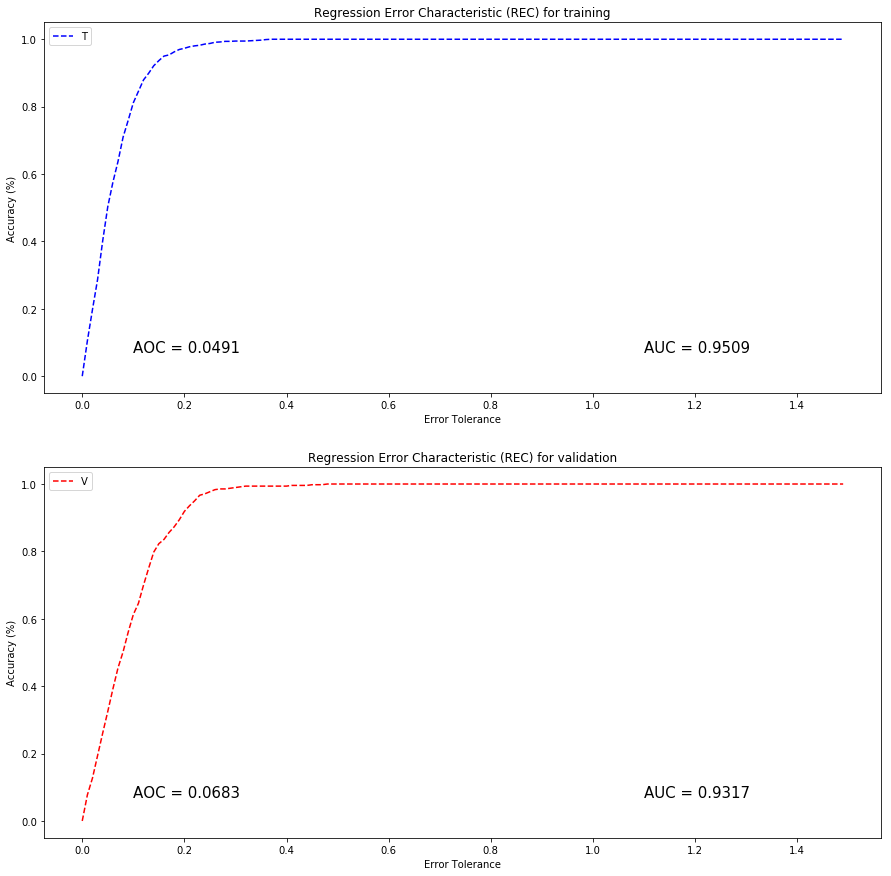

In [55]:
model1 = r.fit(Xtrain, Ttrain, 10)
p = r.predict(model1, Xtrain)
p1 = r.predict(model1, Xvalidate)
TOL, ACC, AUC, AOC = REC(Ttrain, p) #REC for training set
TOL1, ACC1, AUC1, AOC1 = REC(Tvalidate, p) # REC for testing set

plt.figure(figsize = (15,15))
plt.subplot(2,1,1)
plt.title("Regression Error Characteristic (REC) for training")
plt.plot(TOL, ACC, "--b")
plt.xlabel("Error Tolerance")
plt.ylabel("Accuracy (%)")
plt.legend("Training Set")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)
plt.text(0.1, 0.07, "AOC = %0.4f" %AOC , fontsize=15)

plt.subplot(2,1,2)
plt.title("Regression Error Characteristic (REC) for validation")
plt.plot(TOL1, ACC1, "--r")
plt.xlabel("Error Tolerance")
plt.ylabel("Accuracy (%)")
plt.legend("Validation Set")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC1 , fontsize=15)
plt.text(0.1, 0.07, "AOC = %0.4f" %AOC1 , fontsize=15)

## Part 3:  weight vector analysis

As we discussed in class, the magnitude of the weight vector can be interpreted as a measure of feature importance.
Train a ridge regression classifier on a subset of the dataset that you reserved for training.
We will explore the relationship between the magnitude of weight vector components and their relevance to the classification task in several ways.
Each feature is associated with a component of the weight vector.  It can also be associated with the correlation of that feature with the vector of labels.
As we discussed in class, the magnitude of the weight vector can give an indication of feature relevance; another measure of relevance of a feature is its correlation with the labels.  To compare the two, 
create a scatter plot of weight vector components against the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) of the corresponding feature with the labels (again, you can use Numpy to compute it).
What can you conclude from this plot?
The paper ranks features according to their importance using a different approach.  Compare your results with what they obtain.

Next, perform the following experiment:
Incrementally remove the feature with the lowest absolute value of the weight vector and retrain the ridge regression classifier.
Plot RMSE as a function of the number of features that remain on the test set which you have set aside and comment on the results.


**Answers**

* It can be seen from the scatter plot that the features with close to 0 Pearson co-efficient has low weight magnitude and the features with larger Pearson co-efficient magnitude has higher weight magnitude. Which means that there is more correlation between the target and features with higher pearson coefficient magnitude. Similarly there is a higher impact of these features on the dataset as their magnitude of weight is high as well. This theory can be proved by comparing these results to the one in the paper above where they rank the features according to their importance. And from the graph in the paper we see there are 6 important features (viz. sulphate, pH, total sulphur dioxide, %alcohol, volatile acidity and free sulphur dioxide) and in our scatter plot we have 6 points with more significance. Hence, our model is working closely with the models specified in the paper.


* When we incrementally remove the features with lowest absolute value of the weight, we observed that the RMSE of the data set increases. It can be seen from the curve that we get least RMSE when we have all the features. But there is a gradual change in RMSE if we delete the few features with less absolute weight and there is a sudden rise in error when we delete the features with higher weights.  Hence, looking at the graph we can conclude that there are 6 features in the dataset which impact the performance of our regression model more as compared to the rest.

**Calculate Pearson Coefficient**

In [56]:
# Your answer here
w2 = model1['w']
pearson_coefficient= []
for i in range (Xtrain.shape[1]):
    t,_=stats.pearsonr(Xtrain[:,i:i+1], Ttrain)
    pearson_coefficient.append(t[0])

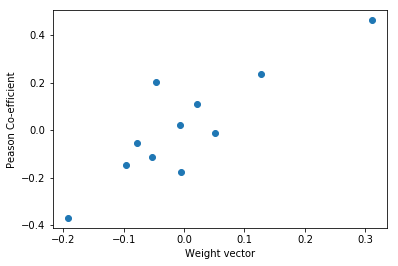

In [57]:
plt.plot(w2[1:12], pearson_coefficient,'o')
plt.xlabel('Weight vector')
plt.ylabel('Peason Co-efficient')

**Function for Weight Vector Analysis**

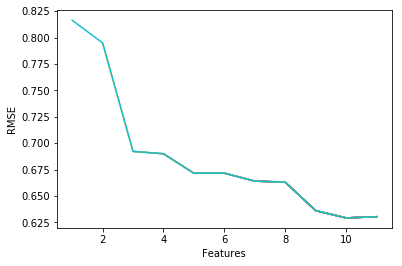

In [58]:
features =[]
rmse = []
Xtrain1 = Xtrain   #Duplicating training data set
Xvalidate1 = Xvalidate   #Duplicating validation data set
lambdas = [0.01, 0.1, 1, 10, 100, 1000]
for lamb in lambdas:
    model = r.fit(Xtrain1, Ttrain, lamb)
    rmse.append(r.evaluate_rmse(model, Xvalidate1, Tvalidate))
    features.append(Xtrain1.shape[1])
    w = np.absolute(model['w'])
    for i in range(Xtrain1.shape[1]-1):
        Xtrain1 = np.delete(Xtrain1, np.argmin(w), axis=1) #Deleting the feature from training set with least weight
        Xvalidate1 = np.delete(Xvalidate1, np.argmin(w) , axis=1)
        model = r.fit(Xtrain1, Ttrain,lamb)
        rmse.append(r.evaluate_rmse(model, Xvalidate1, Tvalidate)) #Deleting the feature from training set with least weight
        features.append(Xtrain1.shape[1])
        w = np.delete(w, np.argmin(w), 0) #Updating the weigth matrix
        plt.plot(features, rmse)
        plt.xlabel('Features')
        plt.ylabel('RMSE')

### Your Report

Answer the questions in the cells reserved for that purpose.

Mathematical equations should be written as LaTex equations; the assignment contains multiple examples of both inline formulas (such as the one exemplifying the notation for the norm of a vector $||\mathbf{x}||$ and those that appear on separate lines, e.g.:

$$
||\mathbf{x}|| = \sqrt{\mathbf{x}^T \mathbf{x}}.
$$



### Submission

Submit your report as a Jupyter notebook via Canvas.  Running the notebook should generate all the plots and results in your notebook.


### Grading 

Here is what the grade sheet will look like for this assignment.  A few general guidelines for this and future assignments in the course:

  * Your answers should be concise and to the point.  We will take off points if that is not the case.
  * Always provide a description of the method you used to produce a given result in sufficient detail such that the reader can reproduce your results on the basis of the description.  You can use a few lines of python code or pseudo-code.


Grading sheet for the assignment:

```
Part 1:  50 points.
(15 points):  Ridge regression is correctly implemented.
(15 points):  Plots of RMSE as a function of lambda are generated correctly.
(20 points):  Discussion of the results

Part 2:  25 points.
(15 points):  REC curves are generated correctly
(10 points):  discussion of REC curves

Part 3:  25 points.
(20 points):  Weight vector analysis
( 5 points):  Comparison to the published results
```


Grading will be based on the following criteria:

  * Correctness of answers to math problems
  * Math is formatted as LaTex equations
  * Correct behavior of the required code
  * Easy to understand plots 
  * Overall readability and organization of the notebook
  * Effort in making interesting observations where requested.
  * Conciseness.  Points may be taken off if the notebook is overly 
  